In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

#import pandas_datareader.data as web

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#importing classes and functions
%run Strategies.ipynb
%run Portfolios.ipynb
%run create_lagged_series.ipynb
%run ratios.ipynb

# Due to presence of NA in some of our data, we include this to suppress warnings.
# We have resolved NA-issues by setting all signals within first 30 days of test to '0'
import warnings
warnings.filterwarnings("ignore")

Statistics of benchmark strategy:
Trading annualised Sharpe Ratio: -0.5468376238864319
Trading daily Sharpe Ratio: -0.03444753238897554
Standard deviation of returns on trading period: 0.003463605586955645
Maximum drawdown on trading period: -0.05208102753003936
Information ratio for trading period: -0.004986714963228185
Number of transactions: 494

Statistics of trading strategy:
Selected number of lag returns: 1
Selected number of HiLo lags: 5
Trading annualised Sharpe Ratio: 1.296456863417563
Trading daily Sharpe Ratio: 0.08166910586013582
Standard deviation of returns on trading period: 0.0031969630625137005
Maximum drawdown on trading period: -0.020255875984172944
Information ratio for trading period: 0.015629761179156345
Number of transactions: 502
Max score: 0.5773508594539939



Statistics of benchmark strategy:
Trading annualised Sharpe Ratio: 0.4619798313666648
Trading daily Sharpe Ratio: 0.02910199391723219
Standard deviation of returns on trading period: 0.0191044140395912


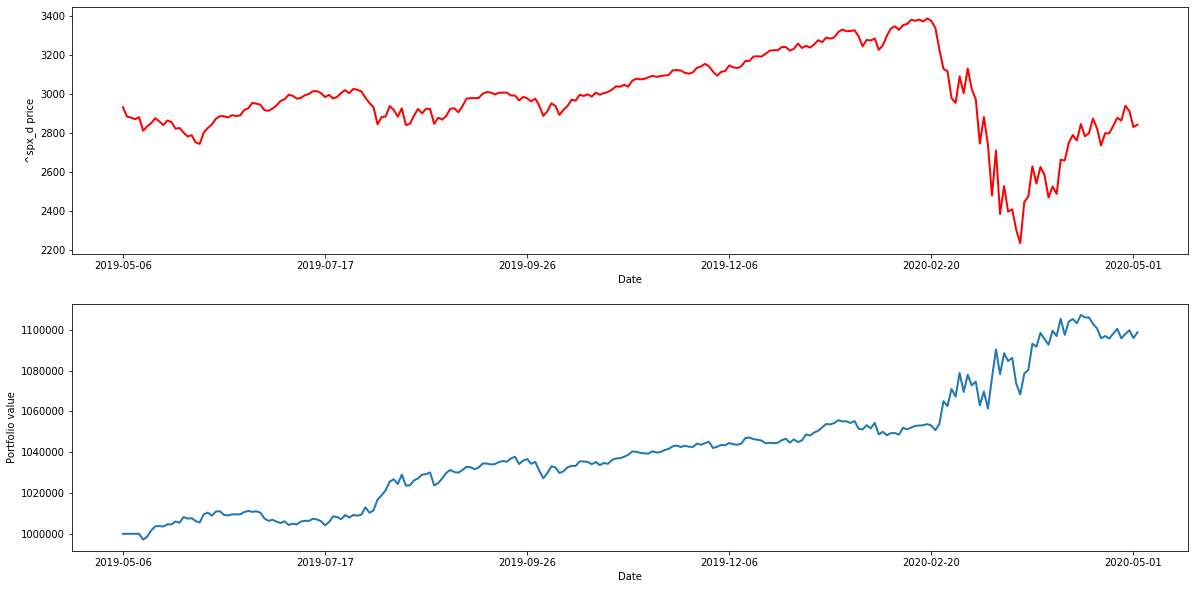

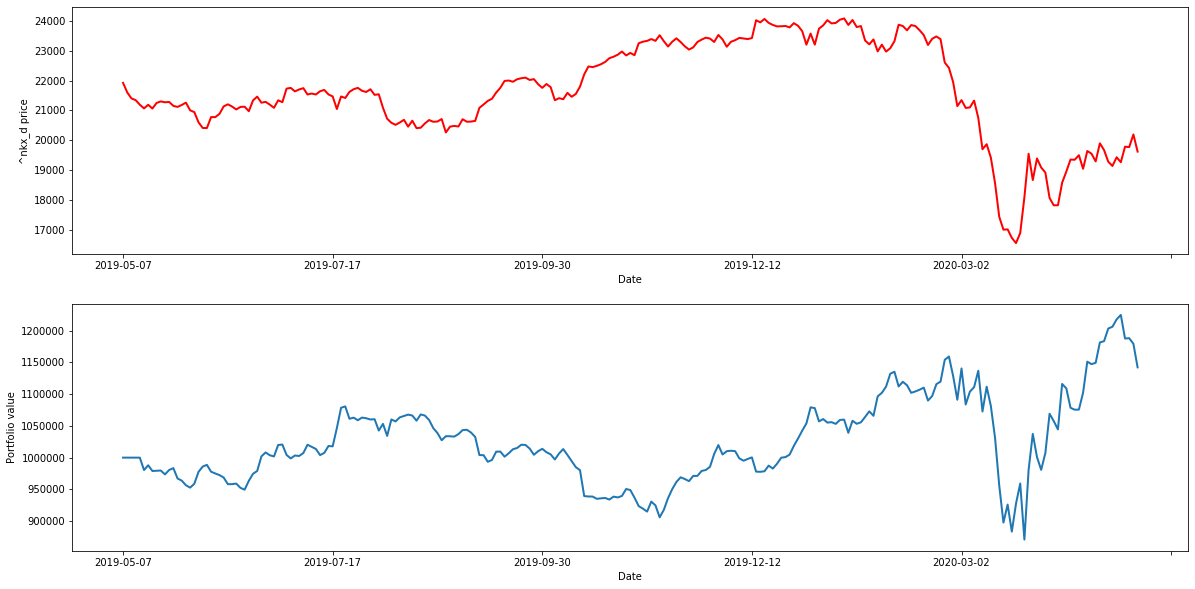

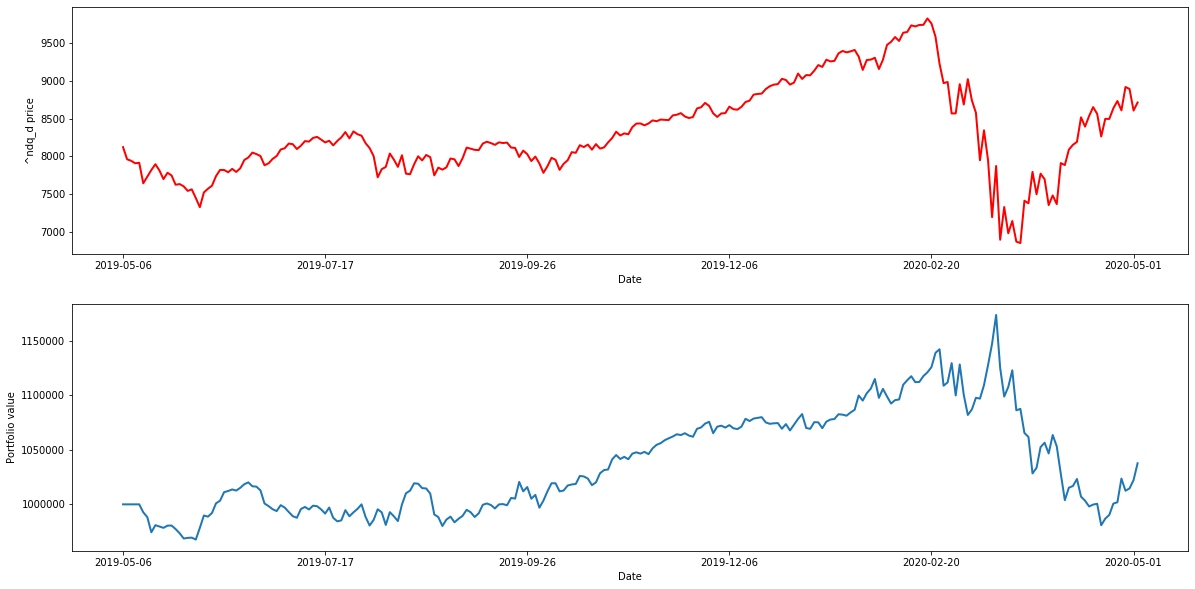

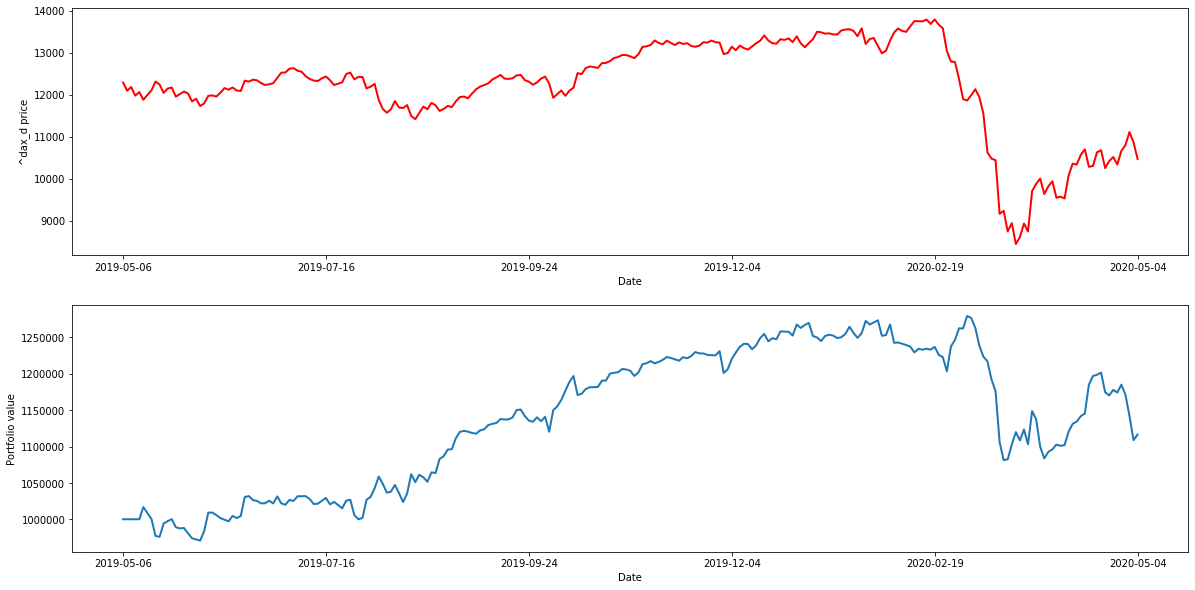

In [11]:
start_period = datetime.date(2015,4,10)
strategy_start_period = datetime.date(2015,5,30)
start_test = datetime.date(2019,5,6)
end_period = datetime.date(2020,5,4)

transaction_cost = 0.004

symbols = ["^spx_d", "^nkx_d", "^ndq_d", "^dax_d"]

for symbol in symbols:
    # Obtain the bars for the underlying instrument    
    bars = pd.read_csv(symbol+".csv", index_col=[0])
    bars = bars[bars.index >= str(start_period)]
    bars = bars[bars.index <= str(end_period)]
    bars["HiLo"] = bars["High"] - bars["Low"]

    bars_treading = pd.read_csv(symbol+".csv", index_col=[0])
    bars_treading = bars_treading[bars_treading.index >= str(start_test)]
    bars_treading = bars_treading[bars_treading.index <= str(end_period)]


    lag_ret_tracker = []
    lag_hilo_tracker = []
    scores = []
    
    # setting range of looking optimal lags
    lag_optimizer = range(1,6)
    hilo_lag_optimizer = range(1,6)
    
    #for loops looking for optimal lags
    for lag_hilo in hilo_lag_optimizer:    
        for lag in lag_optimizer:
            strategy = QDLForecastingStrategy(symbol, bars, strategy_start_period, start_test, end_period, lag, lag_hilo)
            score = strategy.fit_model()
            
            lag_hilo_tracker.append(lag_hilo)
            lag_ret_tracker.append(lag)
            scores.append(score)

    test_results = pd.DataFrame()
    test_results['Lag_HiLo'] = lag_hilo_tracker
    test_results['Lag_Ret'] = lag_ret_tracker
    test_results['Accuracy score'] = scores

    best_lag_ret = lag_ret_tracker[scores.index(max(scores))]
    best_lag_hilo = lag_hilo_tracker[scores.index(max(scores))]
    
    strategy = QDLForecastingStrategy(symbol, bars, strategy_start_period, start_test, end_period, best_lag_ret, best_lag_hilo)
    signals = strategy.generate_signals()

    # Create the portfolio based on the optimized forecaster
    portfolio = MarketIntradayPortfolio(symbol, bars, signals, transaction_cost,             
                                        initial_capital=1000000.0)
    returns = portfolio.backtest_portfolio()
    returns = Create_Daliy_Excess_Returns(returns)
    
    
    
    #Benchmark portfolio
    strategy_benchmark = LongEveryDay(symbol, bars[bars.index >= str(start_test)])
    signals_benchmark = strategy_benchmark.generate_signals()
    portfolio_benchmark = MarketIntradayPortfolio(symbol, bars_treading, signals_benchmark, transaction_cost,             
                                        initial_capital=1000000.0)
    returns_benchmark = portfolio_benchmark.backtest_portfolio()
    returns_benchmark = Create_Daliy_Excess_Returns(returns_benchmark)
    
    #Statistics of benchmark strategy
    print("Statistics of benchmark strategy:")
    print("Trading annualised Sharpe Ratio: " + str(Annual_SR(returns_benchmark)))
    print("Trading daily Sharpe Ratio: " + str(Daily_SR(returns_benchmark)))
    print("Standard deviation of returns on trading period: " + str(Standard_Deviation(returns_benchmark)))
    print("Maximum drawdown on trading period: " + str(Maximum_Drawdown(returns_benchmark)))
    print("Information ratio for trading period: " + str(Information_Ratio(returns_benchmark, bars)))
    print("Number of transactions: " + str(Transaction_Counter(signals_benchmark))+'\n')                   
    
    # Plot results
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')

    # Plot the underlying instrument
    ax1 = fig.add_subplot(211,  ylabel= symbol+' price')
    bars[bars.index >= str(start_test)]['Close'].plot(ax=ax1, color='r', lw=2.)
    # Plot the equity curve
    ax2 = fig.add_subplot(212, ylabel='Portfolio value')
    returns['total'].plot(ax=ax2, lw=2.)
    plt.savefig(symbol+'.png')
    fig.show()
    
    # Printing statistics of the best QDA strategy
    print("Statistics of trading strategy:")
    Print_Ratios(best_lag_ret, best_lag_hilo, returns, bars_treading, signals)
    print("Max score: " + str(max(scores)))
    print('\n\n')